### TPC Benchmarking  
Results Plotting  

In [1]:
import config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})

In [2]:
fpb = "/home/colin/data/tpc_logs/"

In [3]:
test = "TPC-H"
scale_factor = "100"

In [4]:
# H 100GB Scale Factor Queries
fps = ["bq_h_query_times-100GB-h_100GB_01-default-2020-05-01 09:54:14.099669.csv",
       "bq_h_query_times-100GB-h_100GB_02-partition by time-2020-05-01 23:23:17.050195.csv",
       "bq_h_query_times-100GB-h_100GB_03-partition by time & int range-2020-05-01 23:48:05.744723.csv",
       "bq_h_query_times-100GB-h_100GB_04-cluster & partition by time & int range-2020-05-02 00:12:02.612155.csv"]

In [5]:
if "query" in fps[0]:
    x_type = "query_n"
else:
    x_type = "stream_p"

In [6]:
def parse(fp, x_type):
    x_type = {"q":"query_n", "s":"stream_p"}[x_type]
    df = pd.read_csv(fp)
    df.t0 = pd.to_datetime(df.t0)
    df.t1 = pd.to_datetime(df.t1)
    df["dt"] = df.t1 - df.t0
    df["dt_s"] = df.dt.dt.total_seconds()
    return df

In [7]:
df = pd.DataFrame(None)
for _fp in fps:
    _df = parse(fpb + _fp, "q")
    df = pd.concat([df, _df])

In [8]:
df = df.sort_values(by="bq_dataset")

In [9]:
df["description"] = df.desc

In [10]:
dfp_dt = df.pivot(index=x_type, columns="description", values="dt_s")
dfp_bp = df.pivot(index=x_type, columns="description", values="bytes_processed")

In [11]:
def bytes_to_TebiByte(b):
    return b / 1099511627776

In [12]:
dfp_bp = dfp_bp.apply(bytes_to_TebiByte)

### Plot Results

In [13]:
sns.set_style("darkgrid", {"xtick.bottom":True})

In [14]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set2 = sns.color_palette("Set2", 8)
hls = sns.hls_palette(n_colors=6)

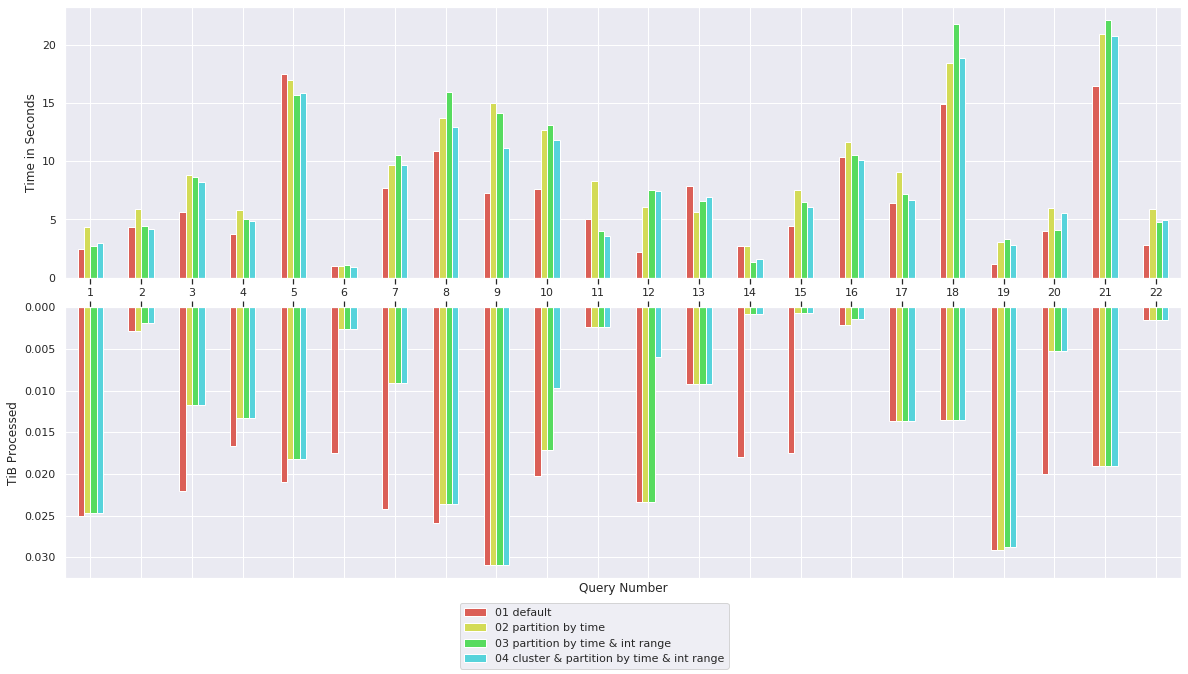

In [15]:
plot_name = "{}_{}GB_{}_comparison.png".format(test, scale_factor, x_type)

# invert bytes processed for plotting
_dfp_bp = dfp_bp.copy() * -1
color_palette = hls
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1 = dfp_dt.plot.bar(ax=ax1, legend=False, color=color_palette)
ax2 = _dfp_bp.plot.bar(ax=ax2, legend=False, color=color_palette);

# set the figure size BEFORE adjusting ticks
fig.set_size_inches(20, 10.5, forward=True)

handles, labels = ax1.get_legend_handles_labels()

ax1.set_ylabel("Time in Seconds")
ax1.set_xlabel(None)
ax1_xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels(labels=[])

ax2.set_ylabel("TiB Processed")
ax2.set_xlabel("Query Number")
ticks =  ax2.get_yticks()
ticks = ["{:01.3f}".format(abs(tick)) for tick in ticks]
ax2.set_yticklabels(ticks);
ax2.xaxis.tick_top()

plt.subplots_adjust(hspace=0.11)
fig.legend(handles, labels, loc="lower center")
plt.savefig(config.fp_plots + config.sep + plot_name, bbox_to_anchor='tight')
print();

In [16]:
dfp_dt.sum()

description
01 default                                    146.489
02 partition by time                          199.327
03 partition by time & int range              191.272
04 cluster & partition by time & int range    177.795
dtype: float64

In [17]:
dfp_bp.sum()

description
01 default                                    0.375916
02 partition by time                          0.274548
03 partition by time & int range              0.272379
04 cluster & partition by time & int range    0.247531
dtype: float64

In [18]:
dfp_bp.sum() * 5

description
01 default                                    1.879580
02 partition by time                          1.372741
03 partition by time & int range              1.361897
04 cluster & partition by time & int range    1.237656
dtype: float64